# 1.Import Spark

In [ ]:
!pip install wget
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 

# 2.Read and check data

In [ ]:
import wget
link_to_data = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv'
DataSet = wget.download(link_to_data)

In [ ]:
!ls

bank.csv  sample_data  spark-2.4.0-bin-hadoop2.7  spark-2.4.0-bin-hadoop2.7.tgz


In [ ]:
# Import the 'bank.csv' as a Spark dataframe and name it as df
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True) 
df.printSchema() 
df.show(5)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+--

In [ ]:
# Check data distribution
# You may use printSchema() 
df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

# 3.Select features

In [ ]:
#Select features ('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit') as df2
df2=df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
df2.show()

+---+-----------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  no|       2|   -1|       0| unknown|    yes|
| 42| management|  single| tertiary|     no|      0|    yes| yes|       2|   -1|       0| unknown|    yes|
| 56| management| married| tertiary| 

In [ ]:
df2.registerTempTable("bank");
print("Total records in the table before removing invalid records:" + str(df2.count()))

Total records in the table before removing invalid records:11162


In [ ]:
#Remove invalid rows/records using spark.sql 
#Removing the rows which having 'null' value for numerical columns and also for String columns removing rows that has value 'unknown' and 'null'
#and only the failure and success rows are present in the potcome column

df2 = spark.sql("""
      Select * FROM bank where NOT 
      (age IS NULL OR job IS NULL OR job = 'unknown' OR marital IS NULL OR marital = 'unknown' OR education IS NULL OR education = 'unknown' OR default IS NULL OR default = 'unknown' OR balance IS NULL OR
       housing IS NULL OR housing = 'unknown' OR loan IS NULL OR loan = 'unknown' OR campaign IS NULL OR pdays IS NULL OR previous IS NULL OR poutcome IS NULL OR poutcome = 'unknown' OR
       deposit IS NULL OR deposit = 'unknown')  AND poutcome IN ('failure','success')

       """);
print("No of rows present after removing invalid records:"+ str(df2.count()))

No of rows present after removing invalid records:2181


In [ ]:
#Covert categorical features to metric features using One hot encoding
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#charColumns list contains string string columns
charColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome'] 
#List that contains stages for the pipeline
stages = []

In [ ]:
# coverting categorical data to Vectorized data
for categoricalColumn in charColumns:
    #Creating a string indexer stage
    stringIndexer = StringIndexer(inputCol = categoricalColumn, outputCol = categoricalColumn + 'Index')
    #creating a one hot encoder stage 
    encoderEstimator = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalColumn + "Vec"])
    #appending String Indexer and encoderEstimater into stages list
    stages += [stringIndexer, encoderEstimator]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericColumns = ['age', 'balance', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "Vec" for c in charColumns] + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Scaledfeatures")
#appending assembler to the stages list
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
#Creating a pieline
pipeline = Pipeline(stages = stages)
pipeline_Model = pipeline.fit(df2)
df3 = pipeline_Model.transform(df2)
df3.printSchema()
df3.show()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultVec: vector (nullable = true)
 |-- housingIndex: double (nullable = false)
 |-- housingVec: vector (nullable = true)
 |-- loanIndex: double (nullable = false)
 |-- loanVec: vect

## 3.1 normalisation

In [ ]:
#Apply Min-Max normalisation on each attribute using MinMaxScaler  
from pyspark.ml.feature import MinMaxScaler
#Normalise the scaledfeatures to get values between 0 and 1 using minmax normalisation
minmaxScaler = MinMaxScaler(inputCol="Scaledfeatures", outputCol="features")
scalerResponse = minmaxScaler.fit(df3)
scalerTransform = scalerResponse.transform(df3)
df3=scalerTransform
#displaying minimum and maximum value using minmax()
print(" scaled features: [%f, %f]" % (minmaxScaler.getMin(), minmaxScaler.getMax()))
#selecting label and features columns
df3.select('label','features').show()
df3.show()

 scaled features: [0.000000, 1.000000]
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,1.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,1.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,1.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,1.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
+-----+--------------------+
only showing top 20 rows

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------+--------------+------------+-------------+--------------+-------------+------------+-------------+------------+------------

In [ ]:
df3.select('label','features').show()
df3.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,1.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,1.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,1.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,1.0,...|
|  0.0|[0.0,1.0,0.0,0.0,...|
+-----+--------------------+
only showing top 20 rows

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------+--------------+------------+-------------+--------------+-------------+------------+-------------+------------+-------------+---------+-------------+-------------

# 4.Unsupervised learning

## 4.1 K-means

In [ ]:
# Perform unsupervised learning on df2 with k-means 
# You can use whole df2 as both training and testing data, 
# Evaluate the clustering result using Accuracy.  
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

In [ ]:
#Performing KMeans on the df2 with k=2 for getting two clusters
kmeans=KMeans(k=2,seed=1)
#providing df3 values to kmeans
responseModel=kmeans.fit(df3)
prediction=responseModel.transform(df3)
evaluator=ClusteringEvaluator() 
result= evaluator.evaluate(prediction)
#Displaying the predictions formed by KMeans
prediction.show()
#Displaying the Accuracy score
print("silohoute distance is \n" +str(result))

centers= responseModel.clusterCenters()

for center in centers:
  print("center:\n",center)

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------+--------------+------------+-------------+--------------+-------------+------------+-------------+------------+-------------+---------+-------------+-------------+-------------+-----+--------------------+--------------------+----------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|jobIndex|        jobVec|maritalIndex|   maritalVec|educationIndex| educationVec|defaultIndex|   defaultVec|housingIndex|   housingVec|loanIndex|      loanVec|poutcomeIndex|  poutcomeVec|label|      Scaledfeatures|            features|prediction|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------+--------------+------------+-------------+--------------+-------------+------------+-------------+------------+-------------+---------+-------------+-------------+-------------+-

In [ ]:
from pyspark.sql.types import DoubleType
df_final= df3.join(prediction)
#casting three prediction column as string value is expected in df final
predict=prediction.withColumn('prediction',prediction['prediction'].cast(DoubleType()))
evalua = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
evalua.evaluate(predict)

0.520861989912884

## 4.2 PCA

In [ ]:
#Generate a scatter plot using the first two PCA components to investigate the data distribution.
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
#principle component analyse the features column to get the PCA features output column
pca= PCA(k=2, inputCol="features", outputCol="pcaFeatures")
responseModel=pca.fit(df3)
pcaResult = responseModel.transform(df3).select("deposit", "features", "pcaFeatures")
pcaResult.show(truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+
|deposit|features                                                                                                                                                                       |pcaFeatures                              |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+
|yes    |[0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.21428571428571427,0.05334664361715079,0.0,0.10550996483001172,0.05555555555555555]                  |[0.9636424850516068,0.3313811478935345]  |
|yes    |[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.5428

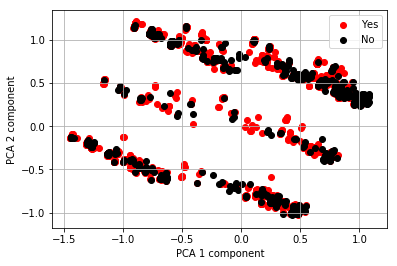

In [ ]:
import matplotlib.pyplot as plt
pcaYes=pcaResult.select("pcaFeatures").where(pcaResult.deposit == 'yes').collect()
pcaNo=pcaResult.select('pcaFeatures').where(pcaResult.deposit=='no').collect()
AcmpYes=[]
AcmpNo=[]
BcmpYes=[]
BcmpNo=[]
#X-axis and Y-axis have plotted using pcaFeatures
for row in pcaYes:
  feature_pca=row['pcaFeatures'].toArray()
  AcmpYes.append(feature_pca[0])
  BcmpYes.append(feature_pca[1])
for row in pcaNo:
  feature_pca=row['pcaFeatures'].toArray()              
  AcmpNo.append(feature_pca[0])
  BcmpNo.append(feature_pca[1])
fig,axis=plt.subplots()
axis.scatter(AcmpYes,BcmpYes,color='red')
axis.scatter(AcmpNo,BcmpNo,color='black')
axis.legend(['Yes','No'])
#providing Xaxis name as PCA1 component 
axis.set_xlabel('PCA 1 component')
#providing Yaxis name as PCA2 component 
axis.set_ylabel('PCA 2 component')
axis.grid()

# 5.Supervised learning

In [ ]:
train, test = df3.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1535
Test Dataset Count: 646


## 5.1 LogisticRegression

In [ ]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
import matplotlib.pyplot as plot
import numpy as np

In [ ]:
# perform logistic regression with features combining all colums of df3 other than deposit and index
logregression=LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)
logregrsion_Response=logregression.fit(train)
co_Efficient=np.sort(logregrsion_Response.coefficients)
co_Efficient


array([-4.06600492, -1.40069787, -1.0115945 , -0.77543111, -0.6673826 ,
       -0.58640696, -0.56288882, -0.39774945, -0.29307701, -0.26309379,
       -0.22315222, -0.1028091 , -0.06422556, -0.04052177, -0.02874555,
       -0.0102023 ,  0.00961051,  0.08309589,  0.26043924,  0.32757334,
        0.38190941,  1.90198322,  2.05048525])

In [ ]:
#print the coefficients and intercept for logistic regression
print("coefficients:" + str(logregrsion_Response.coefficients))
print("coefficients:" + str(logregrsion_Response.intercept))

coefficients:[0.08309589128005467,0.32757334062461385,0.0096105141436745,0.38190941125150324,-0.39774944792469447,-0.22315221504037752,-1.0115944989211938,-0.6673825968709629,-0.06422556314687217,-0.04052176974477358,-0.02874554906578332,-0.1028090951688996,-0.010202304164208824,-0.29307701174854,-0.26309379068036487,-0.7754311127062343,-0.5864069648855801,2.050485245963458,0.2604392385346028,-4.06600492148482,1.9019832166550692,-0.5628888207448501,-1.400697868170869]
coefficients:-0.8480313388202999


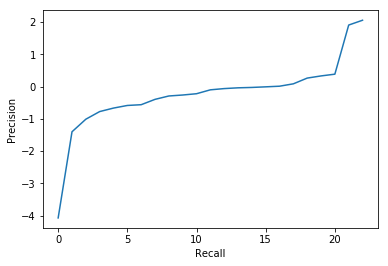

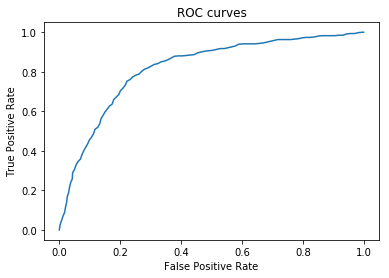

ROC for train Accuracy score:0.8181597573306368
+-------+--------------------+-----+--------------------+----------+--------------------+
|deposit|            features|label|       rawPrediction|prediction|         probability|
+-------+--------------------+-----+--------------------+----------+--------------------+
|    yes|[0.0,0.0,0.0,0.0,...|  0.0|[3.72460351389435...|       0.0|[0.97644553361903...|
|     no|[0.0,0.0,0.0,0.0,...|  1.0|[1.12520322411170...|       0.0|[0.75495258510944...|
|     no|[0.0,0.0,0.0,1.0,...|  1.0|[1.92333675311784...|       0.0|[0.87251006317541...|
|    yes|[1.0,0.0,0.0,0.0,...|  0.0|[2.40934094080927...|       0.0|[0.91753682919934...|
|    yes|[0.0,0.0,0.0,0.0,...|  0.0|[3.99076427786686...|       0.0|[0.98184993391015...|
|    yes|[0.0,0.0,0.0,0.0,...|  0.0|[3.98737557385661...|       0.0|[0.98178944632280...|
|    yes|[0.0,0.0,0.0,0.0,...|  0.0|[3.76254964287486...|       0.0|[0.97730268197705...|
|    yes|[0.0,0.0,0.0,0.0,...|  0.0|[3.8533006995530

In [ ]:
#Exam the coefficients
plot.plot(co_Efficient)
plot.xlabel("Recall")
plot.ylabel("Precision")
plot.show()
# taking summary of logistic regression model
trainSummary=logregrsion_Response.summary
# taking (ROC) dataframe contains false Positive rate and true positive rate 
roc=trainSummary.roc.toPandas()
#ploting FPR and TPR values in x and y axis using matplotlib
plot.plot(roc['FPR'],roc['TPR'])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
#giving title of ROC 
plot.title('ROC curves')
plot.show()
#display ROC value
print("ROC for train Accuracy score:"+str(trainSummary.areaUnderROC)) 
predction=logregrsion_Response.transform(test)
predction.select('deposit','features','label','rawPrediction','prediction','probability').show(10)

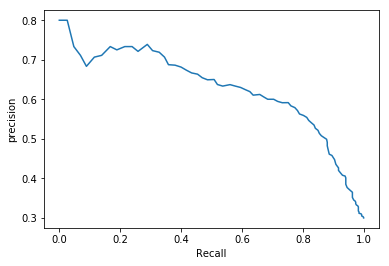

,recall,precision
0,0.000000,0.800000
1,0.026087,0.800000
2,0.047826,0.733333
3,0.069565,0.711111
4,0.089130,0.683333
5,0.115217,0.706667
6,0.139130,0.711111
7,0.167391,0.733333
8,0.189130,0.725000
9,0.215217,0.733333


In [ ]:
precision=trainSummary.pr.toPandas()
#plot the Precision and recall value in the x and y axis 
plot.plot(precision['recall'],precision['precision'])
plot.xlabel('Recall')
plot.ylabel('precision')
plot.show()
# display the precision and recall values
precision

In [ ]:
#evaluate the binaryclassevaluator using prediction values
evaluate=BinaryClassificationEvaluator()
print('ROC area',evaluate.evaluate(predction))

ROC area 0.8045717723137094


In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
Multiclass=MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label',metricName='accuracy')
# printing the accuracy values of prediction
print("Accuracy:",Multiclass.evaluate(predction))

Accuracy: 0.7492260061919505


## 5.2 Decision tree

In [ ]:
#Decision tree 
from pyspark.ml.classification import DecisionTreeClassifier 
#decision tree values are given using featurescol and labelcol and maxdepth
decsiontree=DecisionTreeClassifier(featuresCol='features',labelCol='label',maxDepth=3)
#fit the train values into the decision values
decsiontree_Response=decsiontree.fit(train)
predctiontree=decsiontree_Response.transform(test)
#display the rawPrediction, age job, label, probability, prediction
predctiontree.select('age','job','label','rawPrediction','probability','prediction').show()#Decision tree


+---+-----------+-----+-------------+--------------------+----------+
|age|        job|label|rawPrediction|         probability|prediction|
+---+-----------+-----+-------------+--------------------+----------+
| 18|    student|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 20|    student|  1.0| [207.0,87.0]|[0.70408163265306...|       0.0|
| 21|blue-collar|  1.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 22| management|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 22|    student|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 22|    student|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 22|    student|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 22|    student|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 22|    student|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 23|   services|  0.0| [653.0,57.0]|[0.91971830985915...|       0.0|
| 23|    student|  0.0| [207.0,87.0]|[0.70408163265306...|       0.0|
| 24|     admin.|  1

In [ ]:
evaluator=BinaryClassificationEvaluator()
#evaluateing the ROC data using metricName 
print("TEST data ROC:"+str(evaluator.evaluate(predctiontree,{evaluator.metricName:"areaUnderROC"})))
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
#printing the accuracy value of prediction tree
print("Accuracy of the model:",evaluator.evaluate(predctiontree))

TEST data ROC:0.7793120857636986
Accuracy of the model: 0.7632919461168514


## 5.3 NaiveBayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#proving the naviebayes value to1
naiveBayes=NaiveBayes(smoothing=1)
#fit the train into the naviebayes
navie_Model=naiveBayes.fit(train)
#transform the naviebayes
predctnaive=navie_Model.transform(test)
predctnaive.filter(predctnaive['prediction']==0)\
.select("age","job","probability","label","prediction")\
.orderBy("probability",ascending=False)\
.show(n=10,truncate=30)

+---+-------+------------------------------+-----+----------+
|age|    job|                   probability|label|prediction|
+---+-------+------------------------------+-----+----------+
| 27|student|[0.9773950340740538,0.02260...|  0.0|       0.0|
| 36|student|[0.9772737268046733,0.02272...|  0.0|       0.0|
| 22|student|[0.9740684025844476,0.02593...|  0.0|       0.0|
| 18|student|[0.9685991723641366,0.03140...|  0.0|       0.0|
| 22|student|[0.9682782207895501,0.03172...|  0.0|       0.0|
| 22|student|[0.9680938830856003,0.03190...|  0.0|       0.0|
| 28|student|[0.9647577796177359,0.03524...|  1.0|       0.0|
| 24|student|[0.9646015077834602,0.03539...|  0.0|       0.0|
| 26|student|[0.9643143910687847,0.03568...|  0.0|       0.0|
| 25|student|[0.9637497331970103,0.03625...|  0.0|       0.0|
+---+-------+------------------------------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator=BinaryClassificationEvaluator()
print('ROC test:'+str(evaluator.evaluate(predctnaive,{evaluator.metricName:"areaUnderROC"})))
evaluator=MulticlassClassificationEvaluator(predictionCol='prediction')
#printing the ROC test values and Accuracy of the model
print("accuracy of the model:",evaluator.evaluate(predctnaive))

ROC test:0.5354430515720837
accuracy of the model: 0.7038730257187632
